# Preliminaries

In [1]:
# Required standard libraries
import pandas as pd
import json
import urllib
import requests
import os
import re
import numpy as np
import bs4 as bs
import selenium
import html5lib
#import nltk
import datetime
from selenium import webdriver

# Extractors 
import extract

# Cleansers (cluster specific)
import cleanse

# Normalizer (generalised across all clusters)
from normalize import scaler

# Utils
from utils import utils

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Define filepaths

In [31]:
# Define the export path for all data exports
from pathlib import Path

# Current working directory
cwd = Path('.')

# Folder with data-in artifacts, quired to run this script
data_in = cwd / 'data_in'

# Folder containing data, which has been extracted manually, but entered by a machine
data_sources_raw_manual_machine = cwd / 'data_in' / 'data_raw_manually_extracted' / 'machine_entered'
data_sources_raw_manual_machine.mkdir(parents=True, exist_ok=True)

# Folder containing data, which has been extracted manually, and entered by a human
data_sources_raw_manual_human = cwd / 'data_in' / 'data_raw_manually_extracted' / 'human_entered'
data_sources_raw_manual_human.mkdir(parents=True, exist_ok=True)

# Folder containing manually extracted raw data, ready to be put in the loop
data_sources_staged_raw = cwd / 'data_out' / 'data_staged_raw'
data_sources_staged_raw.mkdir(parents=True, exist_ok=True)

# Folder to export raw data
data_sources_raw = cwd / 'data_out' / 'data_raw'
data_sources_raw.mkdir(parents=True, exist_ok=True)

# Folder to export cleansed data
data_sources_cleansed = cwd / 'data_out' / 'data_cleansed'
data_sources_cleansed.mkdir(parents=True, exist_ok=True)

# Folder to export normalized data
data_sources_normalized = cwd / 'data_out' / 'data_normalized'
data_sources_normalized.mkdir(parents=True, exist_ok=True)

# Folder to export validation results
validation_and_analysis = cwd / 'data_out' / 'data_validation'
validation_and_analysis.mkdir(parents=True, exist_ok=True)

## Load country list and mapping dictionary

In [3]:
# Load the list of countries which contains all different variations of country names 
country_full_list = pd.read_excel(
    data_in / 'all_countrynames_list.xlsx',
    keep_default_na = False).drop_duplicates()

# Create a version of the list with unique ISO2 and ISO3 codes
country_iso_list = country_full_list.drop_duplicates(subset = 'COUNTRY_ISO_2')

# Country CRBA list, this is the list of the countries that should be in the final CRBA indicator list
country_crba_list = pd.read_excel(
    data_in / 'crba_country_list.xlsx',
    header = None,
    usecols = [0, 1], 
    names = ['COUNTRY_ISO_3', 'COUNTRY_NAME']).merge(
        right = country_iso_list[['COUNTRY_ISO_2', 'COUNTRY_ISO_3']],
        how = 'left',
        on='COUNTRY_ISO_3',
        validate = 'one_to_one')

# Run the column mapper script to load the mapping dictionary
with open(data_in / 'column_mapping.py') as file:
    exec(file.read())

# Run the column mapper script to load the mapping dictionary
with open(data_in / 'value_mapping.py') as file:
    exec(file.read())

## Read data dictionary

In [4]:
# sources sheet
crba_data_dictionary_source = pd.read_excel(
    data_in / 'indicator_dictionary_CRBA.xlsx',
    sheet_name = "Source",
    keep_default_na = False
)
    # Delete sources that are deprecated
crba_data_dictionary_source = crba_data_dictionary_source[crba_data_dictionary_source.STATUS != 'Deleted']

# snapshot sheet
crba_data_dictionary_snapshot = pd.read_excel(
    data_in / 'indicator_dictionary_CRBA.xlsx',
    sheet_name = "Snapshot",
    keep_default_na = False
)

# indicator sheet
crba_data_dictionary_indicator = pd.read_excel(
    data_in / 'indicator_dictionary_CRBA.xlsx',
    sheet_name = "Indicator",
    keep_default_na = False,
)

    # Delete indicators that are deprecated
crba_data_dictionary_indicator = crba_data_dictionary_indicator[crba_data_dictionary_indicator.STATUS != 'Deleted']

    # Pandas also reads rows with no content (empty strings)
crba_data_dictionary_indicator = crba_data_dictionary_indicator.loc[crba_data_dictionary_indicator.INDICATOR_NAME != '', :]


# Input lists
crba_data_dictionary_input_list = pd.read_excel(
    data_in / 'indicator_dictionary_CRBA.xlsx',
    sheet_name = "Input_Lists",
    keep_default_na = False
)

# Add 2-digit shortcodes of index, issue and category to indicators sheet
crba_data_dictionary_indicator = crba_data_dictionary_indicator.merge(
    right=crba_data_dictionary_input_list[['INDEX', 'INDEX_CODE']],
    left_on='INDEX',
    right_on='INDEX'
).merge(
    right=crba_data_dictionary_input_list[['ISSUE', 'ISSUE_CODE']],
    left_on='ISSUE',
    right_on='ISSUE'
).merge(
    right=crba_data_dictionary_input_list[['CATEGORY', 'CATEGORY_CODE']],
    left_on='CATEGORY',
    right_on='CATEGORY'
)

# Create indicator code prefix (INDEX-ISSUE_CAEGORY CODE)
crba_data_dictionary_indicator = crba_data_dictionary_indicator.assign(
    INDICATOR_CODE_PREFIX = crba_data_dictionary_indicator.INDEX_CODE +
    "_" +
    crba_data_dictionary_indicator.ISSUE_CODE+
    "_"+
    crba_data_dictionary_indicator.CATEGORY_CODE+
    "_")

# Create indicator code
crba_data_dictionary_indicator = crba_data_dictionary_indicator.assign(
    INDICATOR_CODE = crba_data_dictionary_indicator.INDICATOR_CODE_PREFIX + crba_data_dictionary_indicator.INDICATOR_NAME.apply(
    lambda x: utils.create_ind_code(x)
))

# Check if there are indicators which have been assigned the same indicator code: 
duplicate_codes = crba_data_dictionary_indicator[crba_data_dictionary_indicator.duplicated(subset = 'INDICATOR_CODE', keep = False)][['INDICATOR_CODE', 'INDICATOR_ID']]

if len(duplicate_codes) != 0:
    raise Exception(f"WARNING: Theese are indicator names that have been assigned with the same indicator code {duplicate_codes} \n Please change the names to avoid duplicates")
else:
    print("No duplicate indicator codes present. You can proceed.")

No duplicate indicator codes present. You can proceed.


In [5]:
utils.create_ind_code('Conventions No. 183')

'CONO18'

In [57]:
temo_0 = re.sub("[,.\-;')(]", "", 'Maternity Protection Conventions (No. 103)')

temo_0

'Maternity Protection Conventions No 103'

In [44]:
#utils.create_ind_code('Conventions No. 103 on Maternity Protection')

import nltk

temo_0 = re.sub("[,.-;')(]", "", 'Conventions No 103 on Maternity Protection')

temp = nltk.tokenize.word_tokenize(temo_0)

temp_2 = [word for word in temp if not word in nltk.corpus.stopwords.words()]

temp_2

['Conventions', 'No', 'Maternity', 'Protection']

In [ ]:
import importlib, inspect

extractors = { 
    cls.type: cls for name, cls in inspect.getmembers(
        importlib.import_module("extract"), 
        inspect.isclass
    ) if hasattr(cls, 'type')
}

# Staging (pre-processing) to create exceptional indicators´ raw data 

#

In [5]:
# Pre-processing of exceptional indicators, which require extra transformation
# Important: File requires having filepaths from above defined and pandas already imported
#with open(data_in / 'staging_create_raw_data_machine_entered.py') as file:
#    exec(file.read())

with open(data_in / 'staging_create_raw_data_human_entered.py') as file:
    exec(file.read())

Pre-processing file S_117
Pre-processing file S_118
Pre-processing file S_119
Pre-processing file S_213
Pre-processing file S_228
Pre-processing file S_175
Pre-processing file S_176
Pre-processing file S_179
Pre-processing file S_69
Pre-processing file S_70
Pre-processing file S_96
Pre-processing file S_46
Pre-processing file S_54
Pre-processing file S_128
Pre-processing file S_138
Pre-processing file S_194
Pre-processing file S_195
Pre-processing file S_196
Pre-processing file S_197


# Extract - Transform - Load Loops
## API sources
### CSV API sources

In [5]:
# CSV sources
api_sources = crba_data_dictionary_source[
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (ILO)") | 
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (UNESCO)") | 
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (WHO)") | 
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (UNICEF)") | 
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (NRGI)")
].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# # # # # # # # # # # #
# Delete again (only for temporary debugging 12.11.20)
# # # # # # # # # # # # 
api_sources = api_sources[(api_sources["SOURCE_ID"] == 'S-221')]# | 
# (api_sources["SOURCE_ID"] == 'S-156')]
#api_sources = api_sources[(api_sources["SOURCE_ID"] == 'S-97')]

# define emty dataframe; not necessary if previous defined already
try:
    combined_cleansed_csv
except:
    print("Dataframe cleansed was not defined yet. Now defining it.")
    combined_cleansed_csv = pd.DataFrame()
try:
    combined_normalized_csv
except:
    print("Dataframe normalized was not defined yet. Now defining it.")
    combined_normalized_csv = pd.DataFrame()

# Loop to extract data from API sources
for index, row in api_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    # Extraction section
    # try:
        # Extract data
    # print(row["ENDPOINT_URL"]+"continue here")
    dataframe = extract.CSVExtractor.extract(url = row["ENDPOINT_URL"])
    
    # Save raw data
    dataframe.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";"
        )
    
    # except:
    print("There was a problem with extraction of source {} \n".format(row["SOURCE_ID"]))
    
    
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))
    
    # Cleansing
    dataframe = cleanse.Cleanser().extract_who_raw_data(
        raw_data=dataframe,
        variable_type = row["VALUE_LABELS"],
        display_value_col="Display Value"
    )
    
    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    dataframe = cleanse.Cleanser().extract_year_from_timeperiod(
        dataframe=dataframe,
        year_col="TIME_PERIOD",
        time_cov_col="COVERAGE_TIME"
    )

    dataframe = cleanse.Cleanser().retrieve_latest_observation(
        renamed_data=dataframe,
        dim_cols = sdmx_df_columns_dims,
        country_cols = sdmx_df_columns_country,
        time_cols = sdmx_df_columns_time,
        attr_cols=sdmx_df_columns_attr,
    )
    
    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_x"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_title_string=row["SOURCE_TITLE"],
        source_api_link_string=row["ENDPOINT_URL"]
    )

    dataframe = cleanse.Cleanser().map_values(
        cleansed_data = dataframe,
        value_mapping_dict = value_mapper
    )
    
    dataframe_cleansed = cleanse.Cleanser().encode_categorical_variables(
        dataframe = dataframe,
        encoding_string = row["VALUE_ENCODING"],
        encoding_labels = row["VALUE_LABELS"]
    )

    dataframe_cleansed = cleanse.Cleanser().create_log_report_delete_duplicates(
        cleansed_data=dataframe_cleansed
    )

    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")
    
    # Normalizing
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        )
    
    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["SOURCE_ID"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )

Dataframe cleansed was not defined yet. Now defining it.
Dataframe normalized was not defined yet. Now defining it.

 - - - - - 
 Extracting source S-221 

The following columns are present in the datasets, and this is the number of unique values they have. 
The column DATAFLOW has 1 unique values.
The column CDDDEMINDICS:Demographic indicators has 1 unique values.
The column CDUNIT:Unit has 1 unique values.
The column CDAREAS:Areas has 68 unique values.
The column CDGENDER:Sex has 1 unique values.
The column CDAGE:Age groups has 3 unique values.
The column CDDEMOSTRATIFIERS:Other stratifiers has 15 unique values.
The column TIME_PERIOD:Time period has 16 unique values.
The column OBS_VALUE:Observation value has 38686 unique values.
The column CDDATASOURCE:Data source has 1 unique values.
The column TIME_FORMAT:Time Format has 1 unique values.
There was a problem with extraction of source S-221 


 - - - - - 
 Cleansing source S-221 


 Calling function 'extract_who_raw_data'...

 Call

### JSON API sources

In [7]:
# JSON sources
api_sources = crba_data_dictionary_source[
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (SDG)") | 
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (WB)")
].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# # # # # # # # # # # #
# Delete again (only for temporary debugging 12.11.20)
# # # # # # # # # # # # 
"""
api_sources = api_sources[
    (api_sources["SOURCE_ID"] == 'S-222') | 
    (api_sources["SOURCE_ID"] == 'S-223') |
    (api_sources["SOURCE_ID"] == 'S-224') |
    (api_sources["SOURCE_ID"] == 'S-225') |
    (api_sources["SOURCE_ID"] == 'S-226')
]
"""

# define emty dataframe; not necessary if previous defined already
try:
    combined_cleansed_csv
except:
    print("Dataframe cleansed was not defined yet. Now defining it.")
    combined_cleansed_csv = pd.DataFrame()
try:
    combined_normalized_csv
except:
    print("Dataframe normalized was not defined yet. Now defining it.")
    combined_normalized_csv = pd.DataFrame()

# Loop to extract data from API sources
for index, row in api_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    # Exraction section
    #try:
    # Extract data 
    dataframe = extract.JSONExtractor.extract(url = row["ENDPOINT_URL"])
    
    # Save dataframe
    dataframe.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";")
    # except:
        #print("There was an issue with source {}".format(row["SOURCE_ID"]))
    
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))
    
    # Cleansing in 
    dataframe = cleanse.Cleanser().extract_who_raw_data(
        raw_data=dataframe,
        variable_type = row["VALUE_LABELS"],
        display_value_col="Display Value"
    )
    
    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    # print(dataframe)

    dataframe = cleanse.Cleanser().extract_year_from_timeperiod(
        dataframe=dataframe,
        year_col="TIME_PERIOD",
        time_cov_col="COVERAGE_TIME"
    )

    dataframe = cleanse.Cleanser().retrieve_latest_observation(
        renamed_data=dataframe,
        dim_cols = sdmx_df_columns_dims,
        country_cols = sdmx_df_columns_country,
        time_cols = sdmx_df_columns_time,
        attr_cols=sdmx_df_columns_attr,
    )

    # print(dataframe)

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_x"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        source_title_string=row["SOURCE_TITLE"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_api_link_string=row["ENDPOINT_URL"]
    )

    dataframe = cleanse.Cleanser().map_values(
        cleansed_data = dataframe,
        value_mapping_dict = value_mapper
    )
    
    dataframe_cleansed = cleanse.Cleanser().encode_categorical_variables(
        dataframe = dataframe,
        encoding_string = row["VALUE_ENCODING"],
        encoding_labels = row["VALUE_LABELS"],
        na_encodings = row["NA_ENCODING"]
    )

    dataframe_cleansed = cleanse.Cleanser().create_log_report_delete_duplicates(
        cleansed_data=dataframe_cleansed
    )

    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")
    
    # Normalizing section
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        )
    
    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["SOURCE_ID"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )


 - - - - - 
 Extracting source S-23 

The following columns are present in the datasets, and this is the number of unique values they have. 
The column goal has 1 unique values.
The column target has 1 unique values.
The column indicator has 1 unique values.
The column series has 1 unique values.
The column seriesDescription has 1 unique values.
The column seriesCount has 1 unique values.
The column geoAreaCode has 86 unique values.
The column geoAreaName has 86 unique values.
The column timePeriodStart has 20 unique values.
The column value has 3190 unique values.
The column valueType has 1 unique values.
The column time_detail has 1 unique values.
The column timeCoverage has 1 unique values.
The column upperBound has 1 unique values.
The column lowerBound has 1 unique values.
The column basePeriod has 1 unique values.
The column source has 51 unique values.
The column geoInfoUrl has 1 unique values.
The column footnotes has 17 unique values.
The column attributes.Nature has 2 unique

## HTML Sources
### UN Treaty Sources

In [8]:
# UN Treaty HTML sources
api_sources = crba_data_dictionary_source[
    (crba_data_dictionary_source["SOURCE_BODY"] == "UN Treaties")
].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# define emty dataframe; not necessary if previous defined already
try:
    combined_cleansed_csv
except:
    print("Dataframe cleansed was not defined yet. Now defining it.")
    combined_cleansed_csv = pd.DataFrame()
try:
    combined_normalized_csv
except:
    print("Dataframe normalized was not defined yet. Now defining it.")
    combined_normalized_csv = pd.DataFrame()

# Loop to extract data from API sources
for index, row in api_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    # Exraction section
    dataframe = extract.HTMLExtractor().extract(url = row["ADDRESS"])
    
    # Save dataframe
    dataframe.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";")

    # Cleansing
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))

    # Cleansing
    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    # UN Treaty data specific: Sometimes, countries have footnotes (numbers). These must be purged for the rest of the code to work properly
    dataframe['COUNTRY_NAME'] = dataframe['COUNTRY_NAME'].apply(lambda x: re.sub('\s\d+.*', '', x)) # delete everything after number (and the leading whitespace)

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_x"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        source_title_string=row["SOURCE_TITLE"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_api_link_string=row["ENDPOINT_URL"]
    )

    dataframe_cleansed = cleanse.Cleanser().encode_ilo_un_treaty_data(
        dataframe = dataframe,
        treaty_source_body = row["SOURCE_BODY"]
    )

    dataframe_cleansed = cleanse.Cleanser().create_log_report_delete_duplicates(
        cleansed_data=dataframe_cleansed
    )

    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")
    
    # Normalizing section
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        )
    
    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["SOURCE_ID"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )


 - - - - - 
 Extracting source S-3 

The following columns are present in the datasets, and this is the number of unique values they have. 
The column Participant has 185 unique values.
The column Signature has 59 unique values.
The column Ratification, Accession(a), Succession(d) has 173 unique values.

 - - - - - 
 Cleansing source S-3 


 Calling function 'rename_and_discard_columns'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'encode_ilo_un_treaty_data'...
Cleansing done. This is some basic information about the data: 
 
 There are 195 rows in the dataframe and 0.0% have a NA-value in the column 'OBS_RAW_VALUE

 
 This is the summary of the column 'TIME_PERIOD': count     195.0
mean     2020.0
std         0.0
min      2020.0
25%      2020.0
50%      2020.0
75%      2020.0
max      2020.0
Name: TIME_PERIOD, dtype: float64

 - - - - - 
 Extracting source S-4 

The following columns are present in the datasets, a

## Other sources
### WPA sources

In [17]:
# 1. Create a flat file of all WPA sources
# Read and join all world policy analysis centre data
wpa_child_labor = pd.read_excel(
    io = data_in / 'data_raw_manually_extracted' / 'S_8, S_9' / 'WORLD_child_labor.xls'
)

wpa_childhood = pd.read_excel(
    io = data_in / 'data_raw_manually_extracted' / 'S_10, S_13, S_36, S_45, S_49' / 'WORLD_Dataset_Childhood_4.16.15.xls'
)

wpa_adult_labor = pd.read_excel(
    io = data_in / 'data_raw_manually_extracted' / 'S_40, S_41, S_63, S_64, S_65, S_66, S_67, S_68' / 'WORLD_Dataset_Adult_Labor_9.17.2018.xls'
)

wpa_discrimination = pd.read_excel(
    io = data_in / 'data_raw_manually_extracted' / 'S_42, S_43, S_44' / 'WORLD_discrimination_at_work.xls'
)

# Create list to write a loop
wpa_combined_list=[
    wpa_childhood,
    wpa_adult_labor,
    wpa_discrimination
 ]

# Loop to join all dataframes
wpa_combined = wpa_child_labor

for df in wpa_combined_list:
    wpa_combined = wpa_combined.merge(
        right=df,
        on=['iso2', 'iso3']
    )

# 2. Loop
wpa_sources = crba_data_dictionary_source[
    (crba_data_dictionary_source["SOURCE_BODY"] == "World Policy Analysis Centre")
].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# define emty dataframe; not necessary if previous defined already
try:
    combined_cleansed_csv
except:
    print("Dataframe cleansed was not defined yet. Now defining it.")
    combined_cleansed_csv = pd.DataFrame()
try:
    combined_normalized_csv
except:
    print("Dataframe normalized was not defined yet. Now defining it.")
    combined_normalized_csv = pd.DataFrame()

# Loop to extract data from API sources
for index, row in wpa_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    # Exraction section
    #try:
    # Extract data 
    # Log that we are entering cleasning
    print("\n Extracting data and store it as raw data")

    dataframe = wpa_combined[['iso3', row['WPA_OBS_RAW_COL']]] 
    dataframe['TIME_PERIOD'] = row['WPA_YEAR_COL'] 

    #print(dataframe.head(30))

    # Save dataframe
    dataframe.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";")
    #except:
    print("There was an issue with source {}".format(row["SOURCE_ID"]))
    
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))
    
    # Cleansing 
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))

    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    #print(dataframe['RAW_OBS_VALUE'].unique())

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_x"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_title_string=row["SOURCE_TITLE"],
        source_api_link_string=row["ENDPOINT_URL"]
    )

    dataframe_cleansed = cleanse.Cleanser().encode_categorical_variables(
        dataframe = dataframe,
        encoding_string = row["VALUE_ENCODING"],
        encoding_labels = row["VALUE_LABELS"]
    )

    dataframe_cleansed = cleanse.Cleanser().create_log_report_delete_duplicates(
        cleansed_data=dataframe_cleansed
    )

    
    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )
    

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")

    # Normalizing
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        )

    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["SOURCE_ID"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )

FileNotFoundError: [Errno 2] No such file or directory: 'data_in/data_raw_manually_extracted/S_8, S_9/WORLD_child_labor.xls'

### Python-manually extracted data, which required pre-processing
#### Normal ETL-pipeline


 - - - - - 
 Extracting source S-11 


 - - - - - 
 Cleansing source S-11 


 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 Calling function 'retrieve_latest_observation'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'map_values'...
Values of column: DIM_SEX couldn't be mapped. If column DIM_SEX is present, there is an error with the code. 
Values of column: DIM_EDU_LEVEL couldn't be mapped. If column DIM_EDU_LEVEL is present, there is an error with the code. 
Values of column: DIM_AGE couldn't be mapped. If column DIM_AGE is present, there is an error with the code. 
Values of column: DIM_AGE_GROUP couldn't be mapped. If column DIM_AGE_GROUP is present, there is an error with the code. 
Values of column: DIM_MANAGEMENT_LEVEL couldn't be mapped. If column DIM_MANAGEMENT_LEVEL is present, there is an error with the code. 
Values of column: DIM_AREA_TYPE couldn

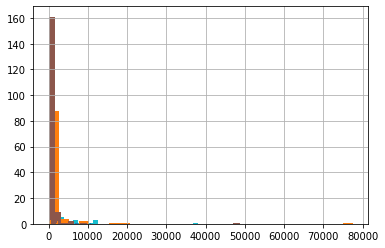

In [6]:
# Manually extracted source, which were pre-processed
manually_extracted_sources = crba_data_dictionary_source[crba_data_dictionary_source.REQUIRE_STAGING == 'Yes'].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# Sources S-168, S-169 and S-170 require a different ETL (i.e. the same ETL as UN Treaties) --> Exclude them from this loop 
manually_extracted_sources = manually_extracted_sources[
(manually_extracted_sources["SOURCE_ID"] != 'S-168') & 
(manually_extracted_sources["SOURCE_ID"] != 'S-169') &
(manually_extracted_sources["SOURCE_ID"] != 'S-170') #&
#(manually_extracted_sources["SOURCE_ID"] == 'S-21')
] 

# define emty dataframe; not necessary if previous defined already
try:
    combined_cleansed_csv
except:
    print("Dataframe cleansed was not defined yet. Now defining it.")
    combined_cleansed_csv = pd.DataFrame()
try:
    combined_normalized_csv
except:
    print("Dataframe normalized was not defined yet. Now defining it.")
    combined_normalized_csv = pd.DataFrame()

# Loop to extract data from API sources
for index, row in manually_extracted_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    dataframe = pd.read_csv(
        data_sources_staged_raw
        / (row["SOURCE_ID"] + "_staged_raw.csv"),
        sep = ';'
    )

    # Save raw data (as actual raw, rather than staged raw data)
    dataframe.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";"
        )
    
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))
    
    """# Cleansing
    dataframe = cleanse.Cleanser().extract_who_raw_data(
        raw_data=dataframe,
        variable_type = row["VALUE_LABELS"],
        display_value_col="Display Value"
    )"""

    # print(dataframe)
    
    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    dataframe = cleanse.Cleanser().extract_year_from_timeperiod(
        dataframe=dataframe,
        year_col="TIME_PERIOD",
        time_cov_col="COVERAGE_TIME"
    )
    
    dataframe = cleanse.Cleanser().retrieve_latest_observation(
        renamed_data=dataframe,
        dim_cols = sdmx_df_columns_dims,
        country_cols = sdmx_df_columns_country,
        time_cols = sdmx_df_columns_time,
        attr_cols=sdmx_df_columns_attr,
    )

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_x"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_title_string=row["SOURCE_TITLE"],
        source_api_link_string=row["ENDPOINT_URL"]
    )

    dataframe = cleanse.Cleanser().map_values(
        cleansed_data = dataframe,
        value_mapping_dict = value_mapper
    )
    
    print(dataframe.RAW_OBS_VALUE.describe())

    dataframe_cleansed = cleanse.Cleanser().encode_categorical_variables(
        dataframe = dataframe,
        encoding_string = row["VALUE_ENCODING"],
        encoding_labels = row["VALUE_LABELS"]
    )

    dataframe_cleansed = cleanse.Cleanser().create_log_report_delete_duplicates(
        cleansed_data=dataframe_cleansed
    )

    # print(dataframe_cleansed)

    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")
    
    # Normalizing
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        log_info = True
        )
    
    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["SOURCE_ID"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )

#### Treaty data pipeline

This pipeline is identical to HTML-Sources: UN Treaties data. It concerns sources S-168, S-169 and S-170

In [80]:
# Manually extracted source, which were pre-processed
manually_extracted_sources = crba_data_dictionary_source[crba_data_dictionary_source.REQUIRE_STAGING == 'Yes'].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# Sources S-168, S-169 and S-170 require a different ETL (i.e. the same ETL as UN Treaties) --> Exclude them from this loop 
manually_extracted_sources = manually_extracted_sources[(manually_extracted_sources["SOURCE_ID"] == 'S-168') | 
(manually_extracted_sources["SOURCE_ID"] == 'S-169') |
(manually_extracted_sources["SOURCE_ID"] == 'S-170') 
] 

# define emty dataframe; not necessary if previous defined already
try:
    combined_cleansed_csv
except:
    print("Dataframe cleansed was not defined yet. Now defining it.")
    combined_cleansed_csv = pd.DataFrame()
try:
    combined_normalized_csv
except:
    print("Dataframe normalized was not defined yet. Now defining it.")
    combined_normalized_csv = pd.DataFrame()

# Loop to extract data from API sources
for index, row in manually_extracted_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    dataframe = pd.read_csv(
        data_sources_staged_raw
        / (row["SOURCE_ID"] + "_staged_raw.csv"),
        sep = ';'
    )

    # Save raw data (as actual raw, rather than staged raw data)
    dataframe.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";"
        )    
    
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))
    
    # Cleansing
    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    # UN Treaty data specific: Sometimes, countries have footnotes (numbers). These must be purged for the rest of the code to work properly
    #dataframe['COUNTRY_NAME'] = dataframe['COUNTRY_NAME'].apply(lambda x: re.sub('\s\d+.*', '', x)) # delete everything after number (and the leading whitespace)

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_x"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        source_title_string=row["SOURCE_TITLE"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_api_link_string=row["ENDPOINT_URL"]
    )

    dataframe_cleansed = cleanse.Cleanser().encode_ilo_un_treaty_data(
        dataframe = dataframe,
        treaty_source_body = row["SOURCE_BODY"]
    )

    dataframe_cleansed = cleanse.Cleanser().create_log_report_delete_duplicates(
        cleansed_data=dataframe_cleansed
    )

    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")
    
    # Normalizing section
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        log_info=True
        )
    
    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["SOURCE_ID"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )

Dataframe cleansed was not defined yet. Now defining it.
Dataframe normalized was not defined yet. Now defining it.

 - - - - - 
 Extracting source S-168 


 - - - - - 
 Cleansing source S-168 


 Calling function 'rename_and_discard_columns'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'encode_ilo_un_treaty_data'...
Cleansing done. This is some basic information about the data: 
 
 There are 195 rows in the dataframe and 0.0% have a NA-value in the column 'OBS_RAW_VALUE

 
 This is the summary of the column 'TIME_PERIOD': count     195.0
mean     2020.0
std         0.0
min      2020.0
25%      2020.0
50%      2020.0
75%      2020.0
max      2020.0
Name: TIME_PERIOD, dtype: float64

 - - - - - 
 Extracting source S-169 


 - - - - - 
 Cleansing source S-169 


 Calling function 'rename_and_discard_columns'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling func

## Export concatented dataframe

In [13]:
# define emty dataframe; not necessary if previous defined already
# combined_cleansed_csv = pd.DataFrame()
combined_normalized_csv = pd.DataFrame()

# Iterate through all files
for file in data_sources_normalized.iterdir():
    try:
        print(file)
        dataframe = pd.read_csv(
                file,
                sep = ';'
            )

        # print(dataframe)

        dataframe['INTERNAL_SOURCE_ID'] = file
        
        combined_normalized_csv = combined_normalized_csv.append(
            other = dataframe
        )
    except:
        print('didnt read file')
        print(file)

"""
# Idenify all dimension columns in combined dataframe
available_dim_cols = []
for col in combined_cleansed_csv.columns:
    dim_col = re.findall("DIM_.+", col)
    # print(dim_col)
    if len(dim_col) == 1:
        available_dim_cols += dim_col

# Fill _T for all NA values of dimension columns
# 5b Fill in current year for time variable
combined_cleansed_csv[available_dim_cols] = combined_cleansed_csv[
    available_dim_cols
].fillna(value="_T")

# Export combined cleansed dataframe as a sample
combined_cleansed_csv.to_csv(
    path_or_buf = cwd / 'data_out' / 'combined_cleansed.csv',
    sep = ";"
)
"""

# # # # # NORMALIZED DATA

# Idenify all dimension columns in combined dataframe
available_dim_cols = []
for col in combined_normalized_csv.columns:
    dim_col = re.findall("DIM_.+", col)
    # print(dim_col)
    if len(dim_col) == 1:
        available_dim_cols += dim_col

# Fill _T for all NA values of dimension columns
# 5b Fill in current year for time variable
combined_normalized_csv[available_dim_cols] = combined_normalized_csv[
    available_dim_cols
].fillna(value="_T")

# S-101 has one duplicate row for country TON, drop that
# This command should commented out when checking for other duplicat
print("This is the number of duplicate rows:")
print(sum(combined_normalized_csv.duplicated()))
print(combined_normalized_csv.loc[combined_normalized_csv.duplicated(), ['COUNTRY_ISO_3','INDICATOR_NAME', 'INDICATOR_CODE']])
# #combined_normalized_csv = combined_normalized_csv.drop_duplicates()

# Export combined cleansed dataframe as a sample
combined_normalized_csv.to_csv(
    path_or_buf = cwd / 'data_out' / 'combined_normalized.csv',
    sep = ";"
)

data_out/data_normalized/S-100_normalized.csv
data_out/data_normalized/S-101_normalized.csv
data_out/data_normalized/S-103_normalized.csv
data_out/data_normalized/S-104_normalized.csv
data_out/data_normalized/S-105_normalized.csv
data_out/data_normalized/S-10_normalized.csv
data_out/data_normalized/S-113_normalized.csv
data_out/data_normalized/S-115_normalized.csv
data_out/data_normalized/S-117_normalized.csv
data_out/data_normalized/S-118_normalized.csv
data_out/data_normalized/S-119_normalized.csv
data_out/data_normalized/S-11_normalized.csv
data_out/data_normalized/S-120_normalized.csv
data_out/data_normalized/S-124_normalized.csv
data_out/data_normalized/S-125_normalized.csv
data_out/data_normalized/S-126_normalized.csv
data_out/data_normalized/S-128_normalized.csv
data_out/data_normalized/S-129_normalized.csv
data_out/data_normalized/S-130_normalized.csv
data_out/data_normalized/S-131_normalized.csv
data_out/data_normalized/S-134_normalized.csv
data_out/data_normalized/S-135_norma

# Validation and exploratory data analysis

### Age of observations

The shape of the dataframe with observations older than 10 years is: (1309, 45) 
 
The number  of observations older than 10 years is: 
 
  INDICATOR_NAME
Average earnings                                    578
Ban on alcohol advertising on national TV             3
Coverage of labour market programmes                 34
Damaged livelihoods associated with disasters\t      21
Deaths associated with disasters\t                    6
Disruption to education services\t                    6
Disruption to health services\t                       4
Education spending\t                                 22
Exclusive breastfeeding\t                            33
Frequency of bullying                                51
New displacements of people by natural disasters      1
Poorest covered by labour market programmes          34
Poorest covered by social insurance                  64
Poverty rates                                        16
Prevalence of hazardous work by adolescents          26
Preva

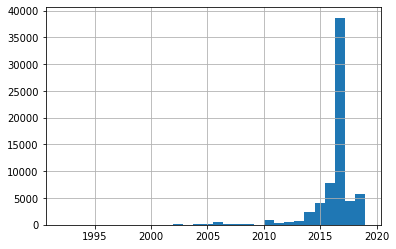

In [32]:
# Visualize distribution of age of observations
combined_normalized_csv.loc[(combined_normalized_csv['TIME_PERIOD']>1990) & (combined_normalized_csv['TIME_PERIOD']<2020), 'TIME_PERIOD'].hist(bins = 30)

# Print number of observations older than 2010
old_data = combined_normalized_csv[combined_normalized_csv['TIME_PERIOD']<2010] 

print(f"The shape of the dataframe with observations older than 10 years is: {old_data.shape} \n ")

# Number of observations older than 2010
old_data_grouped = old_data.groupby('INDICATOR_NAME').count()

print(f"The number  of observations older than 10 years is: \n \n  {old_data_grouped.COUNTRY_ISO_3} \n ")

# # # # Calculate the % of obs older 2010 for each indicator
# Retrieve total number of observations
combined_normalized_csv_grouped = combined_normalized_csv.groupby('INDICATOR_NAME').count()

# Compare the number of rows older 2010 and total number of rows per indicators
old_data_analysis = old_data_grouped[['COUNTRY_ISO_3']].merge(
    right = combined_normalized_csv_grouped[['COUNTRY_ISO_3']],
    on = 'INDICATOR_NAME'
)

# Add column indicating % of obs older
old_data_analysis['OBS_PERCENT_OLDER_2010'] = round((old_data_analysis["COUNTRY_ISO_3_x"] / old_data_analysis["COUNTRY_ISO_3_y"]) * 100, 1) 

print(f"The number  of observations older than 10 years is: \n \n  {old_data_analysis.OBS_PERCENT_OLDER_2010} \n ")

### Number of NaN-countries per indicator

In [34]:
# # # # # # Calculate number of countries with NaN per indicator
countries_na_per_indicator = combined_normalized_csv.loc[combined_normalized_csv.OBS_STATUS == 'O', ].groupby('INDICATOR_CODE').count().sort_values('COUNTRY_ISO_3').COUNTRY_ISO_3

# Export results
countries_na_per_indicator.to_csv(validation_and_analysis / 'COUNTRIES_NA_PER_INDICATOR.csv', sep = ';')

# Log info for user
print(f"The number of countries not NA for a given indicator: \n \n {countries_na_per_indicator}")

The number of countries not NA for a given indicator: 
 
 INDICATOR_CODE
WP_MP_OC_ACPRED      0
CE_FC_OC_OUADPS      0
WP_CL_OC_OUADUS      0
WP_CL_OC_OUADLS      0
CE_RD_OC_LAADDF      1
                  ... 
MP_OL_EN_CHSAEE    138
CE_RD_LF_COEIST    140
MP_OL_OC_PRSEVI    143
WP_DW_OC_GEPAGA    157
WP_MP_EN_PREDSP    195
Name: COUNTRY_ISO_3, Length: 127, dtype: int64


### Number of indicators per... 

* Country
* Index
* Category
* Issue

In [37]:
# # # # # # Calculate number of indicators per country
indicator_per_country = combined_normalized_csv.loc[combined_normalized_csv.SCALED_OBS_VALUE.notna(), ].groupby('COUNTRY_ISO_3', as_index = False).count().sort_values('INDICATOR_CODE').merge(right=country_crba_list, on='COUNTRY_ISO_3').loc[:, ['COUNTRY_ISO_3', 'COUNTRY_NAME_y', 'INDICATOR_CODE']]

indicator_per_country.to_csv(validation_and_analysis /'INDICATOR_SCORES_PER_COUNTRY.csv', sep = ';')
print(f"The number of indicators per country: \n \n {indicator_per_country}")

# # # # # # Calculate the number of indicators per index/ category/ issue
grouping_list = [
    'INDICATOR_INDEX',
    'INDICATOR_ISSUE',
    'INDICATOR_CATEGORY'
]

for group in grouping_list:
    # Create target dataframe
    ndicator_per_x = combined_normalized_csv.groupby([group, 'INDICATOR_CODE'], as_index = False).first().groupby(group).count().INDICATOR_CODE

    # 
    ndicator_per_x.to_csv(validation_and_analysis / ('INDICATORS_PER' + group + '.csv'), sep = ';')
    
    # Print result
    print(f"The number of indicators per {group}: \n \n {ndicator_per_x}")

The number of indicators per country: 
 
     COUNTRY_ISO_3      COUNTRY_NAME_y  INDICATOR_CODE
0             XKX              Kosovo              33
1             LIE       Liechtenstein              60
2             PSE  State of Palestine              65
3             MCO              Monaco              67
4             SMR          San Marino              74
..            ...                 ...             ...
190           UGA              Uganda             140
191           COL            Colombia             141
192           MEX              Mexico             141
193           PER                Peru             142
194           TZA            Tanzania             143

[195 rows x 3 columns]
The number of indicators per INDICATOR_INDEX: 
 
 INDICATOR_INDEX
Community and Environment    57
Marketplace                  39
Workplace                    54
Name: INDICATOR_CODE, dtype: int64
The number of indicators per INDICATOR_ISSUE: 
 
 INDICATOR_ISSUE
Child labour           

### Sanity checks

* Value range always 0 < value < 10


<AxesSubplot:>

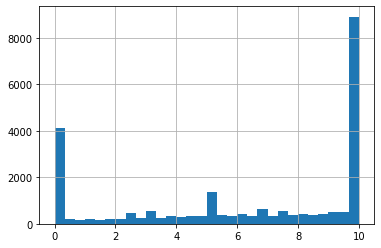

In [121]:
# Visualize distribution of scores across all indicators and countries
combined_normalized_csv.loc[:, 'SCALED_OBS_VALUE'].hist(bins = 30)

# Visualize the distirbution of scores of a specific countries
#combined_normalized_csv.loc[combined_normalized_csv.COUNTRY_ISO_3 == 'DEU', 'SCALED_OBS_VALUE'].hist(bins = 30)

* Is the score of \___ higher than the score of  \____ for some indicator?
    * Germany > Indonesia
    * Panama > Peru 
    * UK > India 
    * Canada > Tanzania
    * Sweden > Mexico

In [38]:
country_pair_list = [
    ['DEU', 'IDN'],
    ['PAN', 'PER'],
    ['GBR', 'IND'],
    ['CAN', 'TZA'],
    ['SWE', 'MEX']
]

for pair in country_pair_list:
    # Subset total dataframe
    df = combined_normalized_csv.loc[
        (combined_normalized_csv['COUNTRY_ISO_3'] == pair[0]) |
        (combined_normalized_csv['COUNTRY_ISO_3'] == pair[1]),
        ['COUNTRY_ISO_3', 'SCALED_OBS_VALUE', 'INDICATOR_CODE', 'INTERNAL_SOURCE_ID']
    ]

    # Check there aren't duplicates
    # TO DO re-write this into an asser statement
    df = df.loc[df.SCALED_OBS_VALUE.notna(), :].drop_duplicates(subset = ['COUNTRY_ISO_3', 'INDICATOR_CODE'])

    # Pivot the table (long to wide format)
    df = df.pivot(index = ['INDICATOR_CODE', 'INTERNAL_SOURCE_ID'], columns = 'COUNTRY_ISO_3', values = 'SCALED_OBS_VALUE')

    # Create new column
    df.loc[
        df[pair[0]] < df[pair[1]],
        'INDICATOR_REQUIRES_DOUBLE_CHECK'
    ] = 'YES'

    # safe dataframe
    df.to_csv(validation_and_analysis / (pair[0] + '-' + pair[1] + '.csv'), sep = ";") 

## Create aggregated scores

In [29]:
# Read combined dataframe
combined_normalized_csv = pd.read_csv(
    cwd / 'data_out' / 'combined_normalized.csv',
    sep = ";"
)

# # # # # # # 
# Index score
index_score = combined_normalized_csv.loc[:, ['INDICATOR_INDEX','COUNTRY_ISO_3', 'SCALED_OBS_VALUE']].groupby(by = ['INDICATOR_INDEX','COUNTRY_ISO_3']).mean()

# Rename column 
index_score = index_score.rename(columns={'SCALED_OBS_VALUE' : 'ATTR_INDEX_SCORE'})

# Temp: Save dataframe
index_score.to_csv(    
    path_or_buf = cwd / 'data_out' / 'index_scores.csv',
    sep = ";")

# Join back to add column to original dataframe
combined_normalized_csv = combined_normalized_csv.merge(
    right=index_score,
    on=['INDICATOR_INDEX','COUNTRY_ISO_3']
)

# # # # # # # 
# Issue score
issue_score = combined_normalized_csv.loc[:, ['INDICATOR_ISSUE','COUNTRY_ISO_3', 'SCALED_OBS_VALUE']].groupby(by = ['INDICATOR_ISSUE','COUNTRY_ISO_3']).mean()

# Rename column
issue_score = issue_score.rename(columns={'SCALED_OBS_VALUE' : 'ATTR_ISSUE_SCORE'})

# Temp: Save dataframe
issue_score.to_csv(    
    path_or_buf = validation_and_analysis / 'issue_scores.csv',
    sep = ";")

# Join back to add column to original dataframe
combined_normalized_csv = combined_normalized_csv.merge(
    right=issue_score,
    on=['INDICATOR_ISSUE','COUNTRY_ISO_3']
)

# # # # # # # # 
# Caregory score
category_score = combined_normalized_csv.loc[:, ['INDICATOR_CATEGORY','COUNTRY_ISO_3', 'SCALED_OBS_VALUE']].groupby(by = ['INDICATOR_CATEGORY','COUNTRY_ISO_3']).mean()

# Rename column
category_score = category_score.rename(columns={'SCALED_OBS_VALUE' : 'ATTR_CATEGORY_SCORE'})

# Temp: Save dataframe
category_score.to_csv(    
    path_or_buf = validation_and_analysis / 'category_scores.csv',
    sep = ";")

# Join back to add column to original dataframe
combined_normalized_csv = combined_normalized_csv.merge(
    right=category_score,
    on=['INDICATOR_CATEGORY','COUNTRY_ISO_3']
)

# Save combined dataframe 
combined_normalized_csv.to_csv(
    path_or_buf = validation_and_analysis / 'combined_normalized.csv',
    sep = ";"
)

# Validation

* 

### Temp to export the results 

In [30]:
# Read combined dataframe
index_score_csv = pd.read_csv(
    cwd / 'data_out' / 'index_scores.csv',
    sep = ";"
)

index_score_csv = index_score_csv.merge(
    right=country_crba_list,
    how='left',
    on='COUNTRY_ISO_3'
)

index_score_csv.to_csv(
    path_or_buf = cwd / 'data_out' / 'index_scores.csv',
    sep = ";"
)

# DEVELOPMENT AND TRASH AREA

### ICRC treaty data

In [6]:
# 

### UNCTAD sources

In [80]:
s_121 = pd.read_excel(    
    data_in
    / "data_raw_manually_extracted"
    / "S-121_CC.xlsx")

s_121['RAW_OBS_VALUE'] = s_121['Title of Legislation/Draft Legislation'].apply(lambda x: '2' if re.search('Draft', x) else '3')

# re.search("Draft", s_121.iloc[242, 1])

s_121[s_121['RAW_OBS_VALUE'] == '2']


# # # # # # 

s_122 = pd.read_excel(    
    data_in
    / "data_raw_manually_extracted"
    / "S-122_DP.xlsx")




s_122['RAW_OBS_VALUE'] = s_122['Title of Legislation/Draft Legislation'].apply(lambda x: '2' if re.search('Draft', x) else '3')

# re.search("Draft", s_121.iloc[242, 1])

s_122[s_122['RAW_OBS_VALUE'] == '2']

# s_122

,Country,Title of Legislation/Draft Legislation,Links to Laws,RAW_OBS_VALUE
72,Iraq,Draft Data Protection and Privacy Law,NaN,2
111,Pakistan,Electronic Data Protection Act 2005 - Draft (i...,http://media.mofo.com/docs/mofoprivacy/PAKISTA...,2
159,Zimbabwe,Draft Data Protection Bill 2016,http://www.techzim.co.zw/wp-content/uploads/20...,2


## Extract selenium sources --> This code is stable as of 06.11.20, TO DO is to put this into a loop (which must be done in container, so I can only do it once James has looked at the issue with Chrome driver)

In [4]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

# Specify location of chromedriver
cwd = os.getcwd()
driver_location = cwd + '\\chromedriver.exe'

# Add option to make it headless (so that it doesn't open an actual chrome window)
options = Options()
options.headless = True
driver = webdriver.Chrome(driver_location, chrome_options=options)

# Get HTTP response
# response = driver.get("https://www.ilo.org/dyn/normlex/en/f?p=NORMLEXPUB:11300:0::NO:11300:P11300_INSTRUMENT_ID:312256:NO")
# response = driver.get("https://www.ilo.org/dyn/normlex/en/f?p=NORMLEXPUB:11300:0::NO::P11300_INSTRUMENT_ID:312283")
# response = driver.get("https://www.ilo.org/dyn/normlex/en/f?p=NORMLEXPUB:11300:0::NO:11300:P11300_INSTRUMENT_ID:312328:NO")
response = driver.get("https://www.ilo.org/dyn/normlex/en/f?p=NORMLEXPUB:11300:0::NO:11300:P11300_INSTRUMENT_ID:312240:NO")

# Get response
# response = driver.get(html_url)

# Retrieve the actual html
html = driver.page_source

# Soupify
soup = bs.BeautifulSoup(html)

# Extract the target table as attribute
target_table = str(
    soup.find_all("table", {"cellspacing": "0", "class": "horizontalLine"})
)

# Create dataframe with the data
raw_data = pd.read_html(io=target_table, header=0)[
    0
]  # return is a list of DFs, specify [0] to get actual DF

# Cleansing
dataframe = cleanse.Cleanser().rename_and_discard_columns(
    raw_data=raw_data,
    mapping_dictionary=mapping_dict,
    final_sdmx_col_list=sdmx_df_columns_all
)

dataframe = cleanse.Cleanser().decompose_country_footnote_ilo_normlex(
    dataframe = dataframe,
    country_name_list = country_full_list.COUNTRY_NAME
)

dataframe = cleanse.Cleanser().add_and_discard_countries(
    grouped_data=dataframe,
    crba_country_list=country_crba_list,
    country_list_full = country_full_list
)

dataframe_cleansed = cleanse.Cleanser().encode_ilo_un_treaty_data(
    dataframe = dataframe,
    treaty_source_body='ILO NORMLEX'
)

# Normalizing section
dataframe_normalized = scaler.normalizer(
    cleansed_data = dataframe_cleansed,
    sql_subset_query_string=None
)

dataframe_normalized

C:\Users\Michael\anaconda3\envs\unicef-test\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: use options instead of chrome_options



 Calling function 'rename_and_discard_columns'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...


,COUNTRY_NAME,ATTR_TREATY_STATUS,ATTR_FOOTNOTE_OF_SOURCE,COUNTRY_ISO_2,COUNTRY_ISO_3,_merge,RAW_OBS_VALUE,ATTR_ENCODING_LABELS,SCALED_OBS_VALUE,OBS_STATUS
0,Afghanistan,In Force,,AF,AFG,both,2,"2=Yes, 1=No; as answer to the following questi...",10.0,nan
1,Albania,In Force,Excluding Article 11 by virtue of the ratifica...,AL,ALB,both,2,"2=Yes, 1=No; as answer to the following questi...",10.0,nan
2,Algeria,In Force,,DZ,DZA,both,2,"2=Yes, 1=No; as answer to the following questi...",10.0,nan
3,Argentina,In Force,,AR,ARG,both,2,"2=Yes, 1=No; as answer to the following questi...",10.0,nan
4,Armenia,In Force,Excluding Article 11 by virtue of the ratifica...,AM,ARM,both,2,"2=Yes, 1=No; as answer to the following questi...",10.0,nan
...,...,...,...,...,...,...,...,...,...,...
192,NaN,NaN,NaN,NaN,USA,right_only,1,"2=Yes, 1=No; as answer to the following questi...",0.0,nan
193,NaN,NaN,NaN,NaN,UZB,right_only,1,"2=Yes, 1=No; as answer to the following questi...",0.0,nan
194,NaN,NaN,NaN,NaN,VUT,right_only,1,"2=Yes, 1=No; as answer to the following questi...",0.0,nan
195,NaN,NaN,NaN,NaN,VNM,right_only,1,"2=Yes, 1=No; as answer to the following questi...",0.0,nan


In [ ]:
re.sub(dataframe["ATTR_FOOTNOTE_OF_SOURCE"][5]
       
# Speifically for ILO NORMLEX - extract country name if additonal info is given
#dataframe["ATTR_FOOTNOTE_OF_SOURCE"] = dataframe["COUNTRY_NAME"]
#dataframe["COUNTRY_NAME"] = dataframe["COUNTRY_NAME"].apply(extract_country_name)
#dataframe["ATTR_FOOTNOTE_OF_SOURCE"] = dataframe.apply(lambda x: re.sub(x['COUNTRY_NAME'], "", x["ATTR_FOOTNOTE_OF_SOURCE"]), 1)


In [ ]:
import requests
import bs4 as bs
import pandas as pd
import selenium
import os
from pathlib import Path
from selenium import webdriver

# cwd = Path('.')
cwd = os.getcwd()

# Current working directory
driver_location = cwd + '\\geckodriver.exe'

print(driver_location)

# Open the targete html. Must be done with selenium, because it doesnt work with normal URL request
#driver = webdriver.Firefox(executable_path="D:/Documents/2020/28_UNICEF/10_working_repo/data-etl/geckodriver.exe")
driver = webdriver.Firefox(executable_path=driver_location)

# Get HTTP response
response = driver.get("https://www.ilo.org/dyn/normlex/en/f?p=NORMLEXPUB:11300:0::NO:11300:P11300_INSTRUMENT_ID:312256:NO")
